In [2]:
import importlib
import project_utils.deciles as deciles
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from general_utils import utils
from general_utils.OverallDetailComparisonPlot import OverallDetailComparisonPlot
import os
from matplotlib import colors as mcolors
import math
import plotly.graph_objects as go
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import general_utils.LDI_VIF as LV
import numpy as np

utils.default_plot_format()
utils.pd_display_settings(3)

ModuleNotFoundError: No module named 'project_utils'

In [ ]:
data_path = r"processed_data\raw_metrics\processed_10min_Nabian.pkl"

In [ ]:
pickled = pd.read_pickle(data_path)
data = pickled["data"]
indicator_columns = pickled["indicator_columns"]
time_metrics = pickled["time_metrics"]
frequency_metrics = pickled["frequency_metrics"]
non_linear_metrics = pickled["non_linear_metrics"]
data.tail()

#indicator_columns.remove('D2')
#non_linear_metrics.remove('D2')

,t_start,t_end,SDRR,RMSSD,pNN50 (%),Mean HR (bpm),ULF Power,ULF Peak Frequency,ULF Peak Power,VLF Power,...,UCr (g),UACR (mg÷g),Complications,Nephropathy,Retinopathy and cataract,DPN,Heart Disease,atherosclerosis or stenosis,Carotid Plaque,Condition
3250,22212,22812,30.89,24.63,3.13,79.80,2.35e-08,0,1.61e-05,4.24e-06,...,7.26,2.88,1,1,0,True,0,0,1,DPN
3251,21611,22211,40.47,34.10,13.03,77.50,1.07e-08,0,9.96e-06,2.39e-06,...,7.26,2.88,1,1,0,True,0,0,1,DPN
3252,21010,21610,38.71,41.98,27.34,75.71,1.28e-09,0.00167,1.49e-06,3.11e-06,...,7.26,2.88,1,1,0,True,0,0,1,DPN
3253,34218,34818,88.51,31.71,12.61,79.37,1.33e-08,0.00167,1.59e-05,3.19e-06,...,7.26,2.88,1,1,0,True,0,0,1,DPN
3254,76304,76903,173.75,220.18,22.22,74.74,3.17e-09,0.00167,3.57e-06,1.2e-06,...,10.23,0.43,1,0,0,True,0,0,1,DPN


In [ ]:
def run_pca(data):
    kmeans = KMeans(n_clusters = 2)
    kmeans.fit(data)
    

    dpn = data["DPN"].astype(int)
    if "DPN" in data.columns:
        data = data.drop(columns = ["DPN"])
    if "id" in data.columns:
        data = data.drop(columns = ["id"])

        
    pca = PCA(3)
    pca.fit(data)
    pca_data = pd.DataFrame(pca.transform(data))
    return pca,kmeans, pca_data, dpn

pca,  kmeans, pca_data, dpn = run_pca(median_pivot)

In [ ]:
median_melted = deciles.produce_median_melt(data, indicator_columns)

metrics = ['HF Power', 'SDRR', 'SD2', 'Mean HR (bpm)', 'LF Power', 'DFA α2', 'S',
       'RMSSD', 'SD1']

metrics = time_metrics
#median_melted = median_melted[median_melted["metric"].isin(metrics)]


median_pivot = median_melted.pivot(index=["id", "DPN"], columns="metric", values="value").reset_index()
print(median_pivot.columns)

Index(['id', 'DPN', 'ApEn', 'D2', 'DFA α1', 'DFA α2', 'HF Peak Frequency',
       'HF Power', 'LF Peak Frequency', 'LF Power', 'LF÷HF Ratio',
       'Mean HR (bpm)', 'RMSSD', 'S', 'SD1', 'SD1÷SD2', 'SD2', 'SDRR',
       'SampEn', 'VLF Peak Frequency', 'VLF Power', 'pNN50 (%)'],
      dtype='object', name='metric')


In [ ]:
def plot_pca(pca_data, kmeans, dpn):


    fig = go.Figure()
    str_labels = [label for label in kmeans.labels_]
    cluster_colors = {0: 'blue', 1: 'red'}
    cluster_colors = dict(zip(range(2), cluster_colors.values()))

    fig.add_trace(go.Scatter3d(
        x=pca_data[0],
        y=pca_data[1],
        z=pca_data[2],
        mode='markers+text',
        marker=dict(
            size=5,
            color=list(map(lambda label: cluster_colors[label], dpn)),
            opacity=0.8
        ),
        text=str_labels,
        textposition='top center'
    ))

    fig.update_layout(
        scene=dict(
            xaxis_title='Component 1',
            yaxis_title='Component 2',
            zaxis_title='Component 3',
            aspectratio=dict(x=1, y=1, z=1),
            aspectmode='cube'
        ),
        width=600, height=500,
        margin=dict(l=10, r=10, b=10, t=10)
    )

    fig.show()


pca,  kmeans, pca_data, dpn = run_pca(median_pivot)
plot_pca(pca_data, kmeans, dpn)

In [ ]:
pca,  kmeans, pca_data, dpn = run_pca(median_pivot[time_metrics+['DPN']])
plot_pca(pca_data, kmeans, dpn)

In [ ]:
pca,  kmeans, pca_data, dpn = run_pca(median_pivot[frequency_metrics+['DPN']])
plot_pca(pca_data, kmeans, dpn)

Frequency domain metrics by themselves are sufficient to isolate DPN

In [ ]:
pca,  kmeans, pca_data, dpn = run_pca(median_pivot[non_linear_metrics+['DPN']])
plot_pca(pca_data, kmeans, dpn)

In [ ]:
pca,  kmeans, pca_data, dpn = LV.run_pca(freq_median[metric+['DPN']])
LV.plot_pca(pca_data, kmeans, dpn)

NameError: name 'run_pca' is not defined

LF÷HF Ratio is vital for PCA isolation of metrics

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Analyzing the PCA results from frequency metrics
# Let's create a visualization to understand the contribution of each frequency metric to the PCA components

import matplotlib.pyplot as plt

pca, clusters, kmeans, pca_data, dpn = run_pca(freq_median[metric+['DPN']])
plot_pca(pca_data, kmeans, dpn)

# Print the equations for each dimension
print("PCA Equations for each dimension:")
for i, component in enumerate(pca.components_):
    equation = f"PC{i+1} = "
    terms = []
    for j, coef in enumerate(component):
        if abs(coef) > 0.01:  # Only include meaningful coefficients
            terms.append(f"{coef:.3f} × {freq_median.columns[j]}")
    equation += " + ".join(terms)
    print(equation)


PCA Equations for each dimension:
PC1 = -0.092 × D2 + -0.415 × DFA α2 + 0.905 × HF Peak Frequency
PC2 = 0.020 × DPN + 0.909 × DFA α2 + 0.416 × HF Peak Frequency
PC3 = 0.097 × DPN + 0.991 × D2 + -0.032 × DFA α2 + 0.086 × HF Peak Frequency


In [ ]:
metric

['VLF Power',
 'VLF Peak Frequency',
 'LF Power',
 'LF Peak Frequency',
 'HF Power',
 'HF Peak Frequency',
 'LF÷HF Ratio']

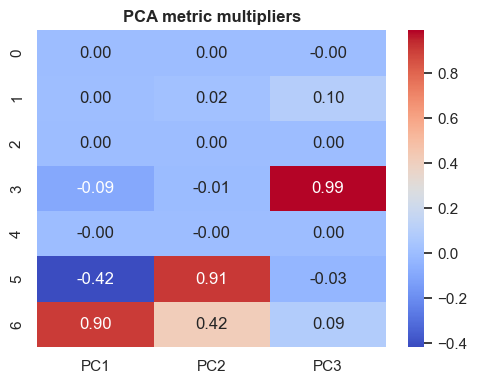

In [ ]:
weights = pd.DataFrame(pca.components_.T, columns=[f"PC{i+1}" for i in range(3)])
metric

plt.figure(figsize=(5, 4))
sns.heatmap(weights, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('PCA metric multipliers')
plt.tight_layout()